<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_03_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
print(sklearn.__version__)

1.3.2


### Load & Preprocess Data

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, make_scorer
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import json
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load and preprocess data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Assuming the `load_and_preprocess_data` function is defined elsewhere
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

### Define Models, Resampling Techniques, and Pipelines

In [4]:

# Define candidate models
candidate_models = {
    'LogReg': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'RF': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': LGBMClassifier(random_state=42, class_weight='balanced', force_row_wise=True),
    'HGB': HistGradientBoostingClassifier(random_state=42, class_weight='balanced')
}

# Define resampling methods
resampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'UnderSampling': RandomUnderSampler(random_state=42)
}

# Create pipelines for each candidate model with resampling
pipelines = {}
for resampling_name, resampler in resampling_methods.items():
    for model_name, model in candidate_models.items():
        pipeline_name = f'{resampling_name}_{model_name}'
        pipelines[pipeline_name] = ImbPipeline(steps=[('preprocessor', preprocessor),
                                                      ('resampler', resampler),
                                                      ('classifier', model)])

# Function to apply class-specific thresholds
def predict_with_class_specific_thresholds(model, X, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X)
    y_pred = np.zeros(y_proba.shape[0])

    # Apply thresholds to obtain predictions
    y_pred[y_proba[:, 1] >= threshold_class_1] = 1  # Predict class 1 for probabilities above threshold_class_1
    y_pred[y_proba[:, 0] >= threshold_class_0] = 0  # Predict class 0 for probabilities above threshold_class_0

    return y_pred

# Function to evaluate models with multiple thresholds
def evaluate_models_with_multiple_thresholds(pipelines, X_train, y_train, X_test, y_test, thresholds_class_1, thresholds_class_0):
    results = []
    for name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)
        for threshold_class_1 in thresholds_class_1:
            for threshold_class_0 in thresholds_class_0:
                y_pred = predict_with_class_specific_thresholds(pipeline, X_test, threshold_class_1, threshold_class_0)
                recall_1 = recall_score(y_test, y_pred, pos_label=1)
                precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
                recall_0 = recall_score(y_test, y_pred, pos_label=0)
                precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
                results.append({
                    'Model': name,
                    'Threshold Class 1': threshold_class_1,
                    'Threshold Class 0': threshold_class_0,
                    'Recall Class 1': recall_1,
                    'Precision Class 1': precision_1,
                    'Recall Class 0': recall_0,
                    'Precision Class 0': precision_0
                })
    return pd.DataFrame(results)

### Define Utility Functions and Evaluate Models with Multiple Thresholds

### Tune and Save the Best Models

In [6]:
# Define the range of thresholds to test
thresholds_class_1 = np.arange(0.2, 0.5, 0.05)
thresholds_class_0 = np.arange(0.2, 0.5, 0.05)

# Evaluate candidate models with multiple thresholds
evaluation_results_multiple_thresholds = evaluate_models_with_multiple_thresholds(pipelines, X_train, y_train, X_test, y_test, thresholds_class_1, thresholds_class_0)

# Find the best threshold combination for each model based on F1 Macro score
evaluation_results_multiple_thresholds['F1 Macro'] = 2 * (evaluation_results_multiple_thresholds['Precision Class 1'] * evaluation_results_multiple_thresholds['Recall Class 1']) / (evaluation_results_multiple_thresholds['Precision Class 1'] + evaluation_results_multiple_thresholds['Recall Class 1'])
best_thresholds = evaluation_results_multiple_thresholds.loc[evaluation_results_multiple_thresholds.groupby('Model')['F1 Macro'].idxmax()]

# Save the best threshold combinations to a JSON file
best_thresholds_dict = best_thresholds.to_dict(orient='records')
with open('best_thresholds.json', 'w') as json_file:
    json.dump(best_thresholds_dict, json_file, indent=4)

print("Best threshold combinations saved to 'best_thresholds.json'")
print("Best threshold combinations for each model:")
print(best_thresholds)

# Custom scorers for recall and precision for class 0 and class 1
scorers = {
    'recall_class_1': make_scorer(recall_score, pos_label=1),
    'precision_class_1': make_scorer(precision_score, pos_label=1),
    'recall_class_0': make_scorer(recall_score, pos_label=0),
    'precision_class_0': make_scorer(precision_score, pos_label=0)
}

# Function to perform grid search for a given model
def tune_model(pipeline, param_grid, X_train, y_train, scoring):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, y_train)
    return grid_search

# Function to tune and save models
def tune_and_save_models(pipelines, param_grids, X_train, y_train, best_thresholds_df, scorers, models_file, params_file):
    best_models = {}
    best_params = {}

    for metric, scorer in scorers.items():
        if 'recall' in metric:
            class_num = metric.split('_')[-1]
            model_name = best_thresholds_df.loc[best_thresholds_df[f'Recall Class {class_num}'].idxmax(), 'Model']
        else:
            class_num = metric.split('_')[-1]
            model_name = best_thresholds_df.loc[best_thresholds_df[f'Precision Class {class_num}'].idxmax(), 'Model']

        tuned_model = tune_model(pipelines[model_name], param_grids[model_name.split('_')[-1]], X_train, y_train, scoring=scorer)

        best_models[metric] = tuned_model.best_estimator_
        best_params[metric] = tuned_model.best_params_

    joblib.dump(best_models, models_file)

    with open(params_file, 'w') as json_file:
        json.dump(best_params, json_file, indent=4)

    return best_models, best_params

# Define parameter grids for the selected models
param_grids = {
    'LogReg': {'classifier__C': [0.1, 1, 10]},
    'RF': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [10, 20]},
    'LGBM': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1]},
    'HGB': {'classifier__max_iter': [100, 200], 'classifier__learning_rate': [0.01, 0.1]}
}

# Tune and save models
best_models_file = 'best_models.pkl'
best_params_file = 'best_params.json'
best_models, best_params = tune_and_save_models(pipelines, param_grids, X_train, y_train, best_thresholds, scorers, best_models_file, best_params_file)

# Print the best parameters
for metric, params in best_params.items():
    print(f"Best parameters for {metric}: {params}")

# Save the best models
joblib.dump(best_models, 'best_models.pkl')
print(f"Best models saved to 'best_models.pkl'")

# Save the best parameters
with open('best_params.json', 'w') as json_file:
    json.dump(best_params, json_file, indent=4)
print(f"Best parameters saved to 'best_params.json'")


[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Total Bins 6533
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 18146, number of negative: 18691
[LightGBM] [Info] Total Bins 6544
[LightGBM] [Info] Number of data points in the train set: 36837, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 5309
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 10618, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best threshold combinations saved to 'best_thresholds.json'
Best threshold combinations for each model:
            

In [7]:
# Print the best parameters
for metric, params in best_params.items():
    print(f"Best parameters for {metric}: {params}")

Best parameters for recall_class_1: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best parameters for precision_class_1: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best parameters for recall_class_0: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best parameters for precision_class_0: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}


In [12]:
import joblib
import json

# Load the best models and parameters
best_models = joblib.load('best_models.pkl')
with open('best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# Load the best thresholds
with open('best_thresholds.json', 'r') as json_file:
    best_thresholds = json.load(json_file)

# Print the models and their parameters used for each metric
print("Best models and their parameters for each metric:")

for metric, model in best_models.items():
    model_name = model.named_steps['classifier'].__class__.__name__
    print(f"\nBest model for {metric}: {model_name}")
    print("Best parameters:")
    for param, value in best_params[metric].items():
        print(f"  {param}: {value}")

# Print the best thresholds
print("\nBest thresholds for each model:")
print(f"Threshold Class 1: {threshold['Threshold Class 1']:.3f}")
print(f"Threshold Class 0: {threshold['Threshold Class 0']:.3f}")

# for threshold in best_thresholds:
#     print(f"\nModel: {threshold['Model']}")
#     print(f"Threshold Class 1: {threshold['Threshold Class 1']:.3f}")
#     print(f"Threshold Class 0: {threshold['Threshold Class 0']:.3f}")
#     print(f"Recall Class 1: {threshold['Recall Class 1']:.3f}")
#     print(f"Precision Class 1: {threshold['Precision Class 1']:.3f}")
#     print(f"Recall Class 0: {threshold['Recall Class 0']:.3f}")
#     print(f"Precision Class 0: {threshold['Precision Class 0']:.3f}")
#     print(f"F1 Macro: {threshold['F1 Macro']:.3f}")


Best models and their parameters for each metric:

Best model for recall_class_1: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 200

Best model for precision_class_1: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 200

Best model for recall_class_0: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 200

Best model for precision_class_0: LGBMClassifier
Best parameters:
  classifier__learning_rate: 0.1
  classifier__n_estimators: 100

Best thresholds for each model:
Threshold Class 1: 0.200
Threshold Class 0: 0.400


### Create and Evaluate Voting and Stacking Classifiers

In [17]:
import joblib
import json
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
import numpy as np
import pandas as pd

# Load the best models, parameters, and thresholds
best_models = joblib.load('best_models.pkl')
with open('best_params.json', 'r') as json_file:
    best_params = json.load(json_file)
with open('best_thresholds.json', 'r') as json_file:
    best_thresholds = json.load(json_file)

# Extract the optimal thresholds for each metric
THRESHOLD_CLASS_1 = best_thresholds[0]['Threshold Class 1']
THRESHOLD_CLASS_0 = best_thresholds[0]['Threshold Class 0']

# Create a list of (name, model) tuples for the VotingClassifier and StackingClassifier
estimators = [
    ('recall_class_1', best_models['recall_class_1']),
    ('precision_class_1', best_models['precision_class_1']),
    ('recall_class_0', best_models['recall_class_0']),
    ('precision_class_0', best_models['precision_class_0'])
]

# Initialize the VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Initialize the StackingClassifier with the best models
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the classifiers on the training data
voting_clf.fit(X_train, y_train)
stacking_clf.fit(X_train, y_train)

# Function to apply class-specific thresholds
def predict_with_class_specific_thresholds(model, X, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = np.zeros_like(y_proba)

    # Apply thresholds
    y_pred[y_proba >= threshold_class_1] = 1
    y_pred[y_proba < threshold_class_0] = 0

    return y_pred

# Predict with the VotingClassifier
y_pred_voting = predict_with_class_specific_thresholds(voting_clf, X_test, THRESHOLD_CLASS_1, THRESHOLD_CLASS_0)

# Predict with the StackingClassifier
y_pred_stacking = predict_with_class_specific_thresholds(stacking_clf, X_test, THRESHOLD_CLASS_1, THRESHOLD_CLASS_0)

# Evaluate the performance of the VotingClassifier
recall_1_voting = recall_score(y_test, y_pred_voting, pos_label=1)
precision_1_voting = precision_score(y_test, y_pred_voting, pos_label=1, zero_division=0)
recall_0_voting = recall_score(y_test, y_pred_voting, pos_label=0)
precision_0_voting = precision_score(y_test, y_pred_voting, pos_label=0, zero_division=0)
f1_macro_voting = f1_score(y_test, y_pred_voting, average='macro')
accuracy_voting = accuracy_score(y_test, y_pred_voting)

# Evaluate the performance of the StackingClassifier
recall_1_stacking = recall_score(y_test, y_pred_stacking, pos_label=1)
precision_1_stacking = precision_score(y_test, y_pred_stacking, pos_label=1, zero_division=0)
recall_0_stacking = recall_score(y_test, y_pred_stacking, pos_label=0)
precision_0_stacking = precision_score(y_test, y_pred_stacking, pos_label=0, zero_division=0)
f1_macro_stacking = f1_score(y_test, y_pred_stacking, average='macro')
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

# Combine the results into a DataFrame
results = pd.DataFrame({
    'Metric': ['Recall Class 1', 'Precision Class 1', 'Recall Class 0', 'Precision Class 0', 'F1 Macro', 'Accuracy'],
    'VotingClassifier': [recall_1_voting, precision_1_voting, recall_0_voting, precision_0_voting, f1_macro_voting, accuracy_voting],
    'StackingClassifier': [recall_1_stacking, precision_1_stacking, recall_0_stacking, precision_0_stacking, f1_macro_stacking, accuracy_stacking]
})

# Set the Metric column as the index
results.set_index('Metric', inplace=True)

# Print the evaluation metrics for VotingClassifier
print("\nVotingClassifier Performance:")
print(f'Recall Class 1: {recall_1_voting:.4f}')
print(f'Precision Class 1: {precision_1_voting:.4f}')
print(f'Recall Class 0: {recall_0_voting:.4f}')
print(f'Precision Class 0: {precision_0_voting:.4f}')
print(f'F1 Macro: {f1_macro_voting:.4f}')
print(f'Accuracy: {accuracy_voting:.4f}')
print("\nClassification Report for VotingClassifier:\n")
print(classification_report(y_test, y_pred_voting))

# Print the evaluation metrics for StackingClassifier
print("\nStackingClassifier Performance:")
print(f'Recall Class 1: {recall_1_stacking:.4f}')
print(f'Precision Class 1: {precision_1_stacking:.4f}')
print(f'Recall Class 0: {recall_0_stacking:.4f}')
print(f'Precision Class 0: {precision_0_stacking:.4f}')
print(f'F1 Macro: {f1_macro_stacking:.4f}')
print(f'Accuracy: {accuracy_stacking:.4f}')
print("\nClassification Report for StackingClassifier:\n")
print(classification_report(y_test, y_pred_stacking))

# Save the final VotingClassifier and StackingClassifier models
joblib.dump(voting_clf, 'best_voting_classifier.pkl')
joblib.dump(stacking_clf, 'best_stacking_classifier.pkl')


[LightGBM] [Info] Number of positive: 5309, number of negative: 5309
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 10618, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 18146, number of negative: 18691
[LightGBM] [Info] Total Bins 6544
[LightGBM] [Info] Number of data points in the train set: 36837, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 18146, number of negative: 18691
[LightGBM] [Info] Total Bins 6544
[LightGBM] [Info] Number of data points in the train set: 36837, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 5309, number of negativ

['best_stacking_classifier.pkl']

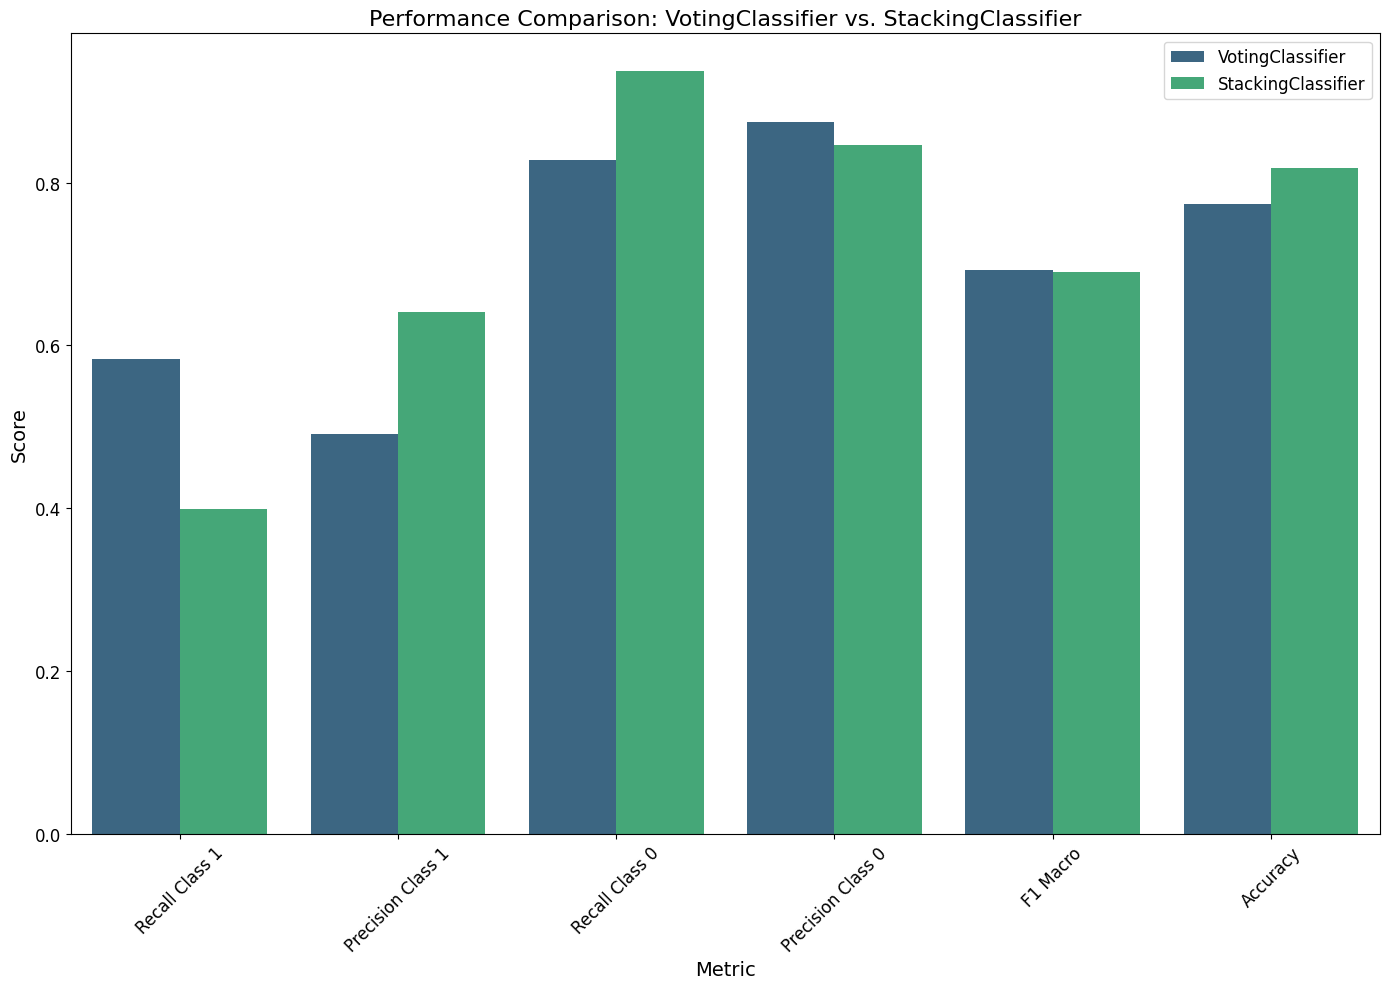

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score

# Calculate accuracy for both models
accuracy_voting = accuracy_score(y_test, y_pred_voting)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

# Combine the results into a DataFrame
results = pd.DataFrame({
    'Metric': ['Recall Class 1', 'Precision Class 1', 'Recall Class 0', 'Precision Class 0', 'F1 Macro', 'Accuracy'],
    'VotingClassifier': [recall_1_voting, precision_1_voting, recall_0_voting, precision_0_voting, f1_macro_voting, accuracy_voting],
    'StackingClassifier': [recall_1_stacking, precision_1_stacking, recall_0_stacking, precision_0_stacking, f1_macro_stacking, accuracy_stacking]
})

# Set the Metric column as the index
results.set_index('Metric', inplace=True)

# Plot the results
plt.figure(figsize=(14, 10))
sns.barplot(data=results.reset_index().melt(id_vars='Metric', var_name='Model', value_name='Score'),
            x='Metric', y='Score', hue='Model', palette='viridis')

plt.title('Performance Comparison: VotingClassifier vs. StackingClassifier', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Metric', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [18]:
results

,VotingClassifier,StackingClassifier
Metric,,
Recall Class 1,0.583271,0.398644
Precision Class 1,0.491117,0.641212
Recall Class 0,0.828376,0.936657
Precision Class 0,0.875000,0.845797
F1 Macro,0.692146,0.690274
Accuracy,0.774167,0.817667
